In [ ]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/pf/g3nr86yn4j71vzzmv6knwdhr0000gp/T/ipykernel_6540/4115428919.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/var/folders/pf/g3nr86yn4j71vzzmv6knwdhr0000gp/T/ipykernel_6540/4115428919.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

torch.set_grad_enabled(False)

<torch.autograd.grad_mode.set_grad_enabled>

In [ ]:
import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

### Indirect Object Identification


In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


##### Example 2

In [ ]:
clean_prompt = "John said to Mary, 'Persistence is all you need.' Mary replied to "

In [ ]:
corrupted_prompt = "John said to Mary, 'Persistence is all you need.' John replied to "

In [ ]:
n_layers = model.cfg.n_layers

In [ ]:
import torch
from transformer_lens import utils

In [ ]:
type(model), n_layers, len(clean_prompt) == len(corrupted_prompt)

(transformer_lens.HookedTransformer.HookedTransformer, 12, True)

In [ ]:
clean_prompt

"John said to Mary, 'Persistence is all you need.' Mary replied to "

In [ ]:
corrupted_prompt

"John said to Mary, 'Persistence is all you need.' John replied to "

Implement activation patching in the pre-residual stream for each layer and position, then compute the logit difference of the patched activation +Don't normalize the logit difference. Explain your code. 

**Hint**: `resid_pre`

In [ ]:
clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)

In [ ]:
clean_logits, clean_activations = model.run_with_cache(clean_tokens)

In [ ]:
n_tokens = clean_tokens.shape[-1]

To perform activation patching, we first create `correct_token` and `incorrect_token` with respect to the `clean_prompt`.

In [ ]:
correct_token = model.to_single_token(" Mary")
incorrect_token = model.to_single_token(" John")

In [ ]:
def patch_residual_stream(activations, hook, position, clean_activations):
    activations[:, position, :] = clean_activations[hook.name][:, position, :]
    return activations

In [ ]:
def compute_logit_diff(logits, correct_token, incorrect_token):
    last_token_logit = logits[:, -1, :]
    logit_of_correct_token = last_token_logit[:, correct_token]
    logit_of_incorrect_token = last_token_logit[:, incorrect_token]    
    logit_diff = logit_of_correct_token - logit_of_incorrect_token
    return logit_diff

In [ ]:
patched_residual_stream_diff = torch.zeros(n_layers, n_tokens)

We then intervene on the corrupted run by patching in activations from the `clean_tokens` for every layer, and position (optional). After patching, we calculate the logit difference in the patched logits of the corrupted prompt.

In [ ]:
for layer in range(n_layers):
    for position in range(n_tokens):
        hook_fn = partial(patch_residual_stream, position=position, clean_activations=clean_activations)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits"
        )
        patched_logit_diff = compute_logit_diff(patched_logits, correct_token, incorrect_token)
        patched_residual_stream_diff[layer][position] = patched_logit_diff

In [ ]:
patched_residual_stream_diff.shape

torch.Size([12, 18])

In [ ]:
prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

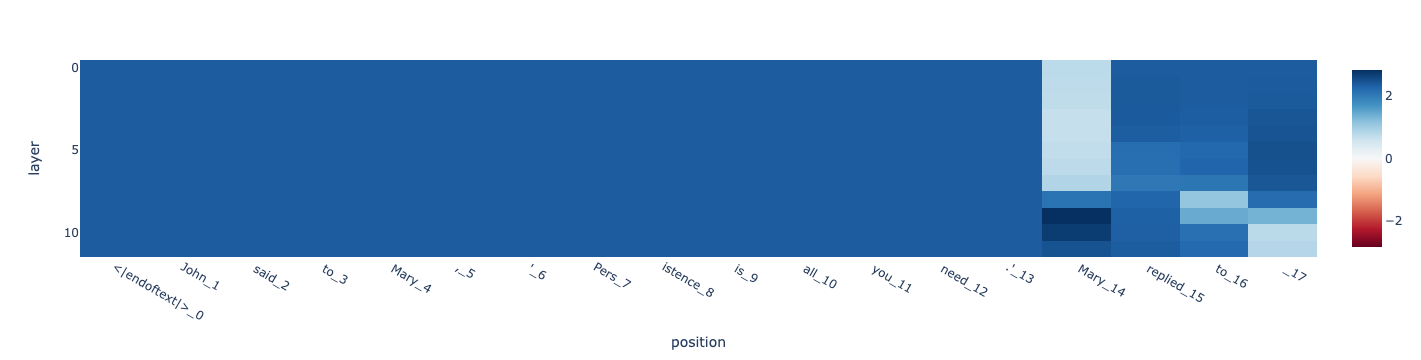

In [ ]:
px.imshow(
    patched_residual_stream_diff.detach().numpy(),
    x=prompt_position_labels,
    labels={"x": "position", "y": "layer"},
    color_continuous_midpoint=0.0, color_continuous_scale="RdBu"
)